<a href="https://colab.research.google.com/github/MarinaWolters/Coding-Tracker/blob/master/CIS5450_Spring23_Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Homework 4: Machine Learning

*Due Date: **27th March 2023 at 11:59PM EST**, 100 points total (= 89 autograded + 11 manually graded).*

**PLEASE READ THE FAQ as you do this assignment!** It's pinned on Ed and we TAs work really hard to keep it updated with everything you might need to know or anything we might have failed to specify. Writing these HWs and test cases gets tricky since students always end up implementing solutions that we did not anticipate and thus could not have prepared the grader correctly for.

# Libraries and Setup Jargon
Run the following cells to set up the notebook.


Please make sure you enter your **8 digit Penn ID** in the  student ID field below.

In [2]:
%%capture
!pip install -i https://test.pypi.org/simple/ penn-grader==0.5.0
from penngrader.grader import *

#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND

STUDENT_ID = 81449864       # YOUR PENN-ID GOES HERE AS AN INTEGER

In [3]:
%%writefile config.yaml

grader_api_url: 'https://wyv616tp17.execute-api.us-east-1.amazonaws.com/default/Grader'
grader_api_key: 'Kd32fl3g3p917iM0zwjiO23Bitj4PO9ga4LektOa'

Writing config.yaml


In [4]:
grader = PennGrader('config.yaml', 'CIS5450O_Sp23_HW4', STUDENT_ID, STUDENT_ID)

PennGrader initialized with Student ID: 81449864

Make sure this correct or we will not be able to store your grade


In [5]:
# Sklearn and Pandas Setup
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split

In [6]:
!apt update

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,549 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,019 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 

# **Part I:** Preprocessing and Modeling in `scikit-learn` (68 points)

## **1.1** Data Loading and Preprocessing


### **1.1.1** Read

We are using one CSV for this homework, `Airbnb_Open_Data.csv` from a Kaggle dataset. The dataset contains a column called price which corresponds to the prices of each Airbnb listing in New York.

To get the data in here:
1. Go to this [Kaggle link](https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata) and create a Kaggle account (unless you already have an account)
2. Go to Account and click on "Create New API Token" to get the API key in the form of a json file `kaggle.json`
3. Upload the `kaggle.json` file to the default location in your Google Drive (Please **DO NOT** upload the json file into any _specific_ folder as it will be difficult for us to debug issues if you deviate from these instructions!).

This can be helpful for your project if you decide to use Kaggle.

In [7]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# Create the kaggle directory and read the uploaded kaggle.json file
# (Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [10]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [11]:
# Download dataset
!!kaggle datasets download -d arianazmoudeh/airbnbopendata

['Downloading airbnbopendata.zip to /content',
 '',
 '  0% 0.00/10.5M [00:00<?, ?B/s]',
 '',
 '100% 10.5M/10.5M [00:00<00:00, 125MB/s]']

In [12]:
# Unzip folder in Colab content folder
!unzip /content/airbnbopendata.zip

Archive:  /content/airbnbopendata.zip
  inflating: Airbnb_Open_Data.csv    


Load `Airbnb_Open_Data.csv` as `df_airbnb`.

In [13]:
# Reads the csv file and saves it to a dataframe called `df_airbnb`
df_airbnb = pd.read_csv('Airbnb_Open_Data.csv')

# Checks out the first five rows
df_airbnb.head(5)

<ipython-input-13-5937e61c197e>:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_airbnb = pd.read_csv('Airbnb_Open_Data.csv')


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


### **1.1.2** Check Nulls

Drop the columns in `df_airbnb` which have greater than 50% Null Values. 

In [14]:
# Drops the columns which have greater than 50% null values. 
df_airbnb = df_airbnb.dropna(thresh=df_airbnb.shape[0]*0.505, how='all', axis=1)
#df_airbnb

In [16]:
#Grader Cell (1 point)
grader.grade(test_case_id = 'check_nulls', answer = df_airbnb.head())

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **1.1.3** Drop Duplicates

Store the number of duplicate rows present in the dataframe into a variable named: `total_duplicates`. Then drop all these duplicate rows from `df_airbnb`.

In [17]:
# Stores the number of duplicate rows in total_duplicates, then drops the duplicates
full_length = len(df_airbnb)
df_airbnb = df_airbnb.drop_duplicates()
clean_length = len(df_airbnb)
total_duplicates = full_length - clean_length
print(full_length, clean_length, total_duplicates)

102599 102058 541


In [18]:
# Checks out first 5 rows of cleaned dataframe
df_airbnb.head(5)

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,Construction year,price,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,2020.0,$966,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,2007.0,$142,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,2005.0,$620,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,2005.0,$368,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,2009.0,$204,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0


In [19]:
# Grader Cell (2 points)
grader.grade(test_case_id = 'drop_duplicates', answer = (df_airbnb.shape,total_duplicates))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.2** EDA

Exploratory Data Analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.


### 1.2.0 Cleaning Column Names


#### (a) Remove spaces

Some of the column names in the dataframe are upper case whereas some are lower case. 

Your **1st task** is to make all column names lower case.

Next, a number of columns have spaces in them - For Example: `Country Code`, `Neighbourhood Group` etc. 

Your **2nd task** is to clean all these column names by replacing all the " " (spaces) with "_". \\
Therefore after you do these two tasks `Country Code` should become `country_code`, `Neighbourhood Group` should become `neighbourhood_group` and so on.

In [20]:
# Changes the column names to lower case and replace the " " with "_"
df_airbnb.rename(str.lower, axis='columns', inplace=True)
df_airbnb.columns = df_airbnb.columns.str.replace(' ', '_')

#### (b) Rename Columns

The `neighbourhood_group` column represents the different boroughs in New York. The `review_rate_number` represents the rating of the airbnb listing from a scale of 1 to 5. The `calculated_host_listings_count` represents the total no. of airbnb listings associated with a particular host.

Our task is to rename these 3 columns in `df_airbnb`.

You should rename these columns are follows:

Rename:
- `neighbourhood_group` to `borough`,
- `review_rate_number` to `rating` , and 
- `calculated_host_listings_count` to `total_host_listings`

In [21]:
# Renames the 3 columns mentioned in the question
df_airbnb.rename(columns={'neighbourhood_group': 'borough', 'review_rate_number': 'rating', 'calculated_host_listings_count': 'total_host_listings'}, inplace=True)

In [22]:
#Grader cell (3 points)
grader.grade(test_case_id = 'cleaning_columns', answer = (df_airbnb.columns))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2.1 Tidying Up

Upon inspection, we see that both the `country` column and the `country_code` column only have one unique value. Thus, we would like to drop these columns as it will not help in analysis or modelling. Your task for this section is to drop the `country` and `country_code` columns from the dataframe.

In [23]:
# Drops 'country' and 'country_code' columns
df_airbnb = df_airbnb.drop(columns=['country', 'country_code'])
df_airbnb.head(5)

,id,name,host_id,host_identity_verified,host_name,borough,neighbourhood,lat,long,instant_bookable,...,construction_year,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,rating,total_host_listings,availability_365
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,False,...,2020.0,$966,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,False,...,2007.0,$142,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,True,...,2005.0,$620,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,True,...,2005.0,$368,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,False,...,2009.0,$204,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0


There are some other columns which are of no use to us. Drop the following columns: `host_id, id, name, host_name, last_review`




In [24]:
# Drops 'id','name','host_name','host_id','last_review' columns
df_airbnb = df_airbnb.drop(columns=['host_id', 'id', 'name', 'host_name', 'last_review'])
df_airbnb.head(5)

,host_identity_verified,borough,neighbourhood,lat,long,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,number_of_reviews,reviews_per_month,rating,total_host_listings,availability_365
0,unconfirmed,Brooklyn,Kensington,40.64749,-73.97237,False,strict,Private room,2020.0,$966,$193,10.0,9.0,0.21,4.0,6.0,286.0
1,verified,Manhattan,Midtown,40.75362,-73.98377,False,moderate,Entire home/apt,2007.0,$142,$28,30.0,45.0,0.38,4.0,2.0,228.0
2,NaN,Manhattan,Harlem,40.80902,-73.94190,True,flexible,Private room,2005.0,$620,$124,3.0,0.0,NaN,5.0,1.0,352.0
3,unconfirmed,Brooklyn,Clinton Hill,40.68514,-73.95976,True,moderate,Entire home/apt,2005.0,$368,$74,30.0,270.0,4.64,4.0,1.0,322.0
4,verified,Manhattan,East Harlem,40.79851,-73.94399,False,moderate,Entire home/apt,2009.0,$204,$41,10.0,9.0,0.10,3.0,1.0,289.0


In [25]:
#Grader Cell (1 point)
grader.grade(test_case_id = 'tidy_up', answer = (df_airbnb.columns))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2.2 Cleaning Price and Service Fee Columns

The `price` and `service_fee` columns are of type `object` and have '$\$$' sign and commas in them. For Example: $\$$1,000. We would like to clean up the `price` and `service_fee` columns so that the columns now are of type **`float`** and have no '$\$$' sign or commas. So, $\$$1,000 would become `1000.0`

**Note: If a price or service_fee row value is NaN, let it remain as NaN**

In [26]:
df_airbnb.dtypes

host_identity_verified     object
borough                    object
neighbourhood              object
lat                       float64
long                      float64
instant_bookable           object
cancellation_policy        object
room_type                  object
construction_year         float64
price                      object
service_fee                object
minimum_nights            float64
number_of_reviews         float64
reviews_per_month         float64
rating                    float64
total_host_listings       float64
availability_365          float64
dtype: object

In [27]:
# Cleans up the 'price' column
df_airbnb['price'] = df_airbnb['price'].str.replace(',', '')
df_airbnb['price'] = df_airbnb['price'].str.replace('$', '')

<ipython-input-27-6aca435a9ee0>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_airbnb['price'] = df_airbnb['price'].str.replace('$', '')


In [28]:
# Cleanes up the 'service_fee' column and converts both columns to float
df_airbnb['service_fee'] = df_airbnb['service_fee'].str.replace(',', '')
df_airbnb['service_fee'] = df_airbnb['service_fee'].str.replace('$', '')
df_airbnb = df_airbnb.astype({'price': float, 'service_fee': float})
df_airbnb.head(5)

<ipython-input-28-f2a903a64fc0>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_airbnb['service_fee'] = df_airbnb['service_fee'].str.replace('$', '')


,host_identity_verified,borough,neighbourhood,lat,long,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,number_of_reviews,reviews_per_month,rating,total_host_listings,availability_365
0,unconfirmed,Brooklyn,Kensington,40.64749,-73.97237,False,strict,Private room,2020.0,966.0,193.0,10.0,9.0,0.21,4.0,6.0,286.0
1,verified,Manhattan,Midtown,40.75362,-73.98377,False,moderate,Entire home/apt,2007.0,142.0,28.0,30.0,45.0,0.38,4.0,2.0,228.0
2,NaN,Manhattan,Harlem,40.80902,-73.94190,True,flexible,Private room,2005.0,620.0,124.0,3.0,0.0,NaN,5.0,1.0,352.0
3,unconfirmed,Brooklyn,Clinton Hill,40.68514,-73.95976,True,moderate,Entire home/apt,2005.0,368.0,74.0,30.0,270.0,4.64,4.0,1.0,322.0
4,verified,Manhattan,East Harlem,40.79851,-73.94399,False,moderate,Entire home/apt,2009.0,204.0,41.0,10.0,9.0,0.10,3.0,1.0,289.0


In [29]:
#Grader (4 points)
grader.grade(test_case_id = 'clean_price_service_fee', answer = df_airbnb[:10000])

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2.3 Reviews Per Month

The `reviews_per_month` column has NaN values in it. NaN in this column represents that there were no reviews for that airbnb listing.

Think of a way to fill in the NaN values in this column given the above information.

In [30]:
# Fills in the NaN values in 'reviews_per_month'
df_airbnb['reviews_per_month'] = df_airbnb['reviews_per_month'].fillna(0)

In [31]:
#Grader (2 points)
grader.grade(test_case_id = 'fill_reviews_per_month', answer = df_airbnb[:10000])

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2.4 Clean up Borough Column

Each row in the `borough` column can be one of the following 5 values: `Manhattan, Brooklyn, Queens, Bronx, Staten Island` 

But, if you inspect the `borough` column, you'll notice a couple rows with incorrectly spelled names. Your task is to change these incorrectly spelled names to the correct borough name. For example, an incorrect name could be `brookln`, and you should change this value to `Brooklyn`.

Then, create a Pandas series `borough_counts` that shows the number of AirBnB listings (i.e. number of rows) for each of the 5 boroughs. Call this series `borough_counts`.

***Hint:*** Look at documentation of .unique() and .value_counts() and see how to obtain the unique values in a column and their respective counts


In [32]:
# Looks into unique values of a column
df_airbnb['borough'].unique()

array(['Brooklyn', 'Manhattan', 'brookln', 'manhatan', 'Queens', nan,
       'Staten Island', 'Bronx'], dtype=object)

In [33]:
# Fixes the incorrect borough names and store the counts in 'borough_counts'
df_airbnb['borough'] = df_airbnb['borough'].str.replace('manhatan', 'Manhattan')
df_airbnb['borough'] = df_airbnb['borough'].str.replace('brookln', 'Brooklyn')

In [34]:
borough_counts = df_airbnb['borough'].value_counts()
borough_counts

Manhattan        43558
Brooklyn         41631
Queens           13197
Bronx             2694
Staten Island      949
Name: borough, dtype: int64

In [35]:
#Grader (2 point)
grader.grade(test_case_id = 'clean_borough', answer = borough_counts)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2.5 Drop NAs

After the pre-processing we have done above, the total no. of null values in each column should be relatively low compared to the overall size of the dataframe. Your next step is to remove all NA values from the `df_airbnb` dataframe.


In [36]:
# Drops all NA values
df_airbnb.dropna(inplace=True)

In [37]:
#Grader (1 point)
grader.grade(test_case_id = 'drop_na', answer = df_airbnb.shape)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2.6 Average Prices of Listings by Neighbourhood and Borough



####(a) Top Neighbourhoods by Average Price

`Task`:
For each borough find the top 5 neighbourhoods with the highest average price of listings.

You should return a dataframe called `neighbourhood_prices_top_5` with the following columns:
- `'borough'`
- `'neighbourhood'`
- `'avg_price'`

The number of rows in this dataframe should be **25**, this is because there are 5 boroughs and you have been asked to find the top 5 neighbourhoods by average price in each of these boroughs.

**NOTE**: When returning the `neighbourhood_prices_top_5` dataframe make sure to:
- sort the `'borough'` column in **ascending order** (alphabetically)
- sort the `'avg_price'` column in **descending Order** (highest to lowest)

In [38]:
# Creates nei_df with only needed 3 columns
nei_df = pd.DataFrame()
nei_df[['borough', 'neighbourhood', 'avg_price']] = df_airbnb[['borough', 'neighbourhood', 'price']]
nei_df.head(5)

,borough,neighbourhood,avg_price
0,Brooklyn,Kensington,966.0
1,Manhattan,Midtown,142.0
3,Brooklyn,Clinton Hill,368.0
4,Manhattan,East Harlem,204.0
5,Manhattan,Murray Hill,577.0


In [39]:
# For each borough find the top 5 neighbourhoods with the highest average price of listings.
neighbourhood_prices_top_5 = nei_df.groupby(['borough', 'neighbourhood'])['avg_price'].mean().reset_index()
neighbourhood_prices_top_5 = neighbourhood_prices_top_5.sort_values(by=['borough', 'avg_price', 'neighbourhood'], ascending=False)
neighbourhood_prices_top_5 = neighbourhood_prices_top_5.groupby('borough')['borough', 'neighbourhood', 'avg_price'].head(5)

# Sorts two columns first by ascending then by descending order
neighbourhood_prices_top_5 = neighbourhood_prices_top_5.sort_values(by=['borough', 'avg_price'], ascending=[True, False])
neighbourhood_prices_top_5

<ipython-input-39-47b30dfe5f0a>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  neighbourhood_prices_top_5 = neighbourhood_prices_top_5.groupby('borough')['borough', 'neighbourhood', 'avg_price'].head(5)


,borough,neighbourhood,avg_price
11,Bronx,East Morrisania,786.950000
34,Bronx,Riverdale,752.388889
21,Bronx,Morris Heights,742.891304
27,Bronx,North Riverdale,733.629630
31,Bronx,Pelham Bay,730.341463
83,Brooklyn,Mill Basin,775.142857
48,Brooklyn,Bath Beach,723.086957
63,Brooklyn,Columbia St,708.022989
78,Brooklyn,Gravesend,705.985185
64,Brooklyn,Coney Island,695.260000


In [40]:
#Grader (5 points)
grader.grade(test_case_id = 'neighbourhood_prices', answer = neighbourhood_prices_top_5)

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### (b) Graph

*Manually graded*: **5 points**

Using `neighbourhood_prices_top_5`, plot a bar chart with y axis as `avg_price` and x axis as `neighbourhood`. The x axis should contain 25 bars (5 bars for each borough), and the bars should represent the average prices in those neighbourhoods. 

Make sure that:
- The graph has an appropriate title along with axis labels
- Bars are color coded by `borough`:
  - You must include the corresponding legend/color key for each `borough`
- Your graph is clearly legible and there should not be overlapping text

**REMINDER:** Do NOT save the plot as a separate image file! You must ensure that the plot is displayed in your Colab notebook before submission. If you do not hit "Restart and Run All" to ensure this before your final submission, we _**will deduct -3 points from your final score.**_



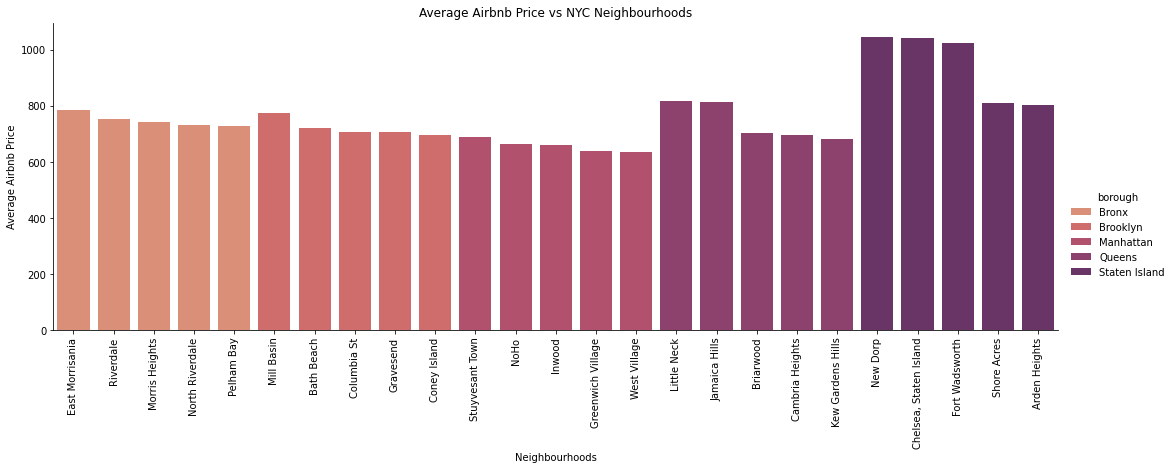

In [105]:
# Plots the graph (5 points)
# height & aspect - allow to play with the size of figure plot
# hue - color codes each borough
# dodge - normalizes the width of bars
g = sns.catplot(data=neighbourhood_prices_top_5,
                x='neighbourhood',
                y='avg_price',
                hue='borough',
                kind='bar',
                height=5,
                aspect=3,
                dodge=False,
                palette='flare')

# Rotates the names on neibourhood along x-axis
g.set_xticklabels(rotation=90)

# Adds x, y labels & title of the graph
g.set_axis_labels("Neighbourhoods", "Average Airbnb Price")
g.set(title="Average Airbnb Price vs NYC Neighbourhoods")

### **1.2.7** Correlation of Feature Variables

With multiple features, it can be somewhat exhausting to do bivariate analysis on every possible pair of features. While you certainly should, your first instinct should be to check for the correlation between features since certain models (e.g. Linear Regression) won't work well if we have strong multicollinearity.

_**Isolating Numerics from Categorical Features**_

Before anything else, it may help to create groups of the numeric vs. categorical variables.

Your task is to split the `df_airbnb` dataframe into 2 dataframes:

1. `numerics_df`: This dataframe contains all numerical columns from `df_airbnb`

2. `categorical_df`: This dataframe contains all categorical columns from `df_airbnb`

In [42]:
# Splits 'df_airbnb' into 'numerics_df' and 'categorical_df' that contain all numeric/categorial columns
numerics_df = df_airbnb[['lat', 'long', 'construction_year', 'price', 'service_fee', 
                         'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                         'rating', 'total_host_listings', 'availability_365']]

categorical_df = df_airbnb[['host_identity_verified', 'borough', 'neighbourhood', 
                            'instant_bookable', 'cancellation_policy', 'room_type']]    

In [43]:
#Grader (2 points)
grader.grade(test_case_id = 'check_correlation', answer = [numerics_df.columns, categorical_df.columns])

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.





_**Correlation Heatmap**_ \\
*Manually graded*

Next, create a correlation matrix using `numerics_df` and call it `corr_matrix`. Using the correlation matrix, generate a correlation heatmap for these numeric features. Look into how to use the `seaborn` library to do this _(imported as `sns` above)_.

Like the plot in 1.2.6, we are going to be rather strict about the details and presentation when we manually grade your correlation heatmap (out of **3 points**). Make sure your correlation heatmap meets the following criteria:
- Ensure that your heatmap is appropriately sized: all feature labels should be visible on both the $x$-axis and $y$-axis
- Use the `RdBu` color map to ensure that negative correlations are red and positive correlations are blue
- Standardize the color scale so that -1 takes the darkest red color, 0 is totally white, and +1 takes the darkest blue color 

In [44]:
corr_matrix = numerics_df.corr()
corr_matrix

,lat,long,construction_year,price,service_fee,minimum_nights,number_of_reviews,reviews_per_month,rating,total_host_listings,availability_365
lat,1.000000,0.073370,0.005053,-0.004001,-0.003977,0.017827,-0.025895,-0.026369,-0.003404,0.032450,-0.005090
long,0.073370,1.000000,0.001331,0.003705,0.003699,-0.042247,0.071982,0.121823,0.014239,-0.105585,0.059138
construction_year,0.005053,0.001331,1.000000,-0.004062,-0.004041,0.002278,0.002792,0.004656,0.005306,-0.002269,-0.007850
price,-0.004001,0.003705,-0.004062,1.000000,0.999991,-0.005658,0.005044,0.005061,-0.005349,-0.001297,-0.003509
service_fee,-0.003977,0.003699,-0.004041,0.999991,1.000000,-0.005633,0.005021,0.005043,-0.005353,-0.001289,-0.003499
minimum_nights,0.017827,-0.042247,0.002278,-0.005658,-0.005633,1.000000,-0.054619,-0.097521,-0.000776,0.090533,0.063407
number_of_reviews,-0.025895,0.071982,0.002792,0.005044,0.005021,-0.054619,1.000000,0.622209,-0.016951,-0.080848,0.099486
reviews_per_month,-0.026369,0.121823,0.004656,0.005061,0.005043,-0.097521,0.622209,1.000000,0.033492,-0.039612,0.073696
rating,-0.003404,0.014239,0.005306,-0.005349,-0.005353,-0.000776,-0.016951,0.033492,1.000000,0.024340,-0.006186
total_host_listings,0.032450,-0.105585,-0.002269,-0.001297,-0.001289,0.090533,-0.080848,-0.039612,0.024340,1.000000,0.160304


Text(0.5, 1.0, 'Correlation Heatmap')

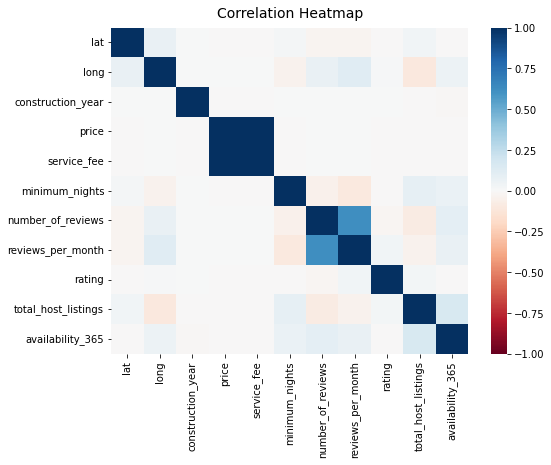

In [45]:
# Plots correlation heatmap (3 points) #annot=True
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='RdBu', mask=corr_matrix == 0).set_title('Correlation Heatmap', fontdict={'fontsize': 14}, pad=10)

## **1.3** Feature Engineering

Feature engineering is the process of applying domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms.

### **1.3.1** Changing service_fee to categorical

We see from the Correlation Matrix, that the `service_fee` variable is highly correlated with `price`. In Section 1.4 we will be doing a regression task with `price` as the dependent variable. We believe that `service_fee` is a good predictor for price.

Note that since `service_fee` is directly calculated from the price, `service_fee` is highly correlated with `price`. Ideally we would want to not use `service_fee`, and instead collect other features. But in this HW, we will try to reduce the information contained in the `service_fee` column. We want to change this variable into a categorical variable which would decrease its correlation. This way, we could use this new categorical variable in our modeling. 

Create a new column called `service_fee_factor` which can contain two values (0,1) that respectively represent low and high service fee in the following manner:

`service_fee_factor = 0, if service_fee < 50th percentile`

`service_fee_factor = 1, if service_fee >= 50th percentile`

Hint: Recall that the 50th percentile is the median, and can be computed via `.median()`.

***Side Note:*** Most Hosts pay a flat service fee of 3% of the booking subtotal. The subtotal is your nightly price plus any optional fees you charge guests, like a cleaning fee, and doesn't include Airbnb fees and taxes. Thus, if we were building a price prediction model we won't have access to the service fee for new listings. Thus, it won't be preferable to include `service_fee` or `service_fee_factor` in our model. A work-around would be to first run a clustering model to predict the `service_fee_factor` using other features (excluding `price`), and then run our regression model to predict `price`. 

In [46]:
# Calculates the median (50th percentile) and defines a simple categorization function
service_fee_median = df_airbnb['service_fee'].median()
service_fee_median

def apply_median(x):
  if x < service_fee_median:
    return 0
  else:
    return 1

In [47]:
# Changes service_fee to categorical (adds 'service_fee_factor' column)
df_airbnb['service_fee_factor'] = df_airbnb['service_fee'].apply(apply_median)
#df_airbnb

In [48]:
df_airbnb.drop(columns='service_fee', axis=1, inplace=True)

In [49]:
#Grader (2 points)
grader.grade(test_case_id = 'zero_one_tuple', answer = (df_airbnb['service_fee_factor'].value_counts()[0], df_airbnb['service_fee_factor'].value_counts()[1]))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **1.3.2** Proposed Ranking System for Ordinal Encoding

The `cancellation_policy` column, as the name suggests, contains information on how lenient the cancellation policy is. As such, in order to make the data useful as feature variables, we encode these policies using _Ordinal Encoding_. If a certain type of cancellation policy is strict, we want it to have a higher ranked value. Create a new column called `"cancellation_factor"` that contains these ordinal encodings (ranks).

**Clarifications**:
- To eliminate ambiguity, please rank the cancellation policy according to: `flexible < moderate < strict`
- If the cancellation policy is flexible, assign the lowest rank of 0 to it.

In [50]:
# Calculates the factor, assigns 0 to flexible, 1 to moderate, and 2 to strict
def apply_cancel_factor(x):
  if x == 'flexible':
    return 0
  elif x == 'moderate':
    return 1
  else:
    return 2

In [51]:
# Creates a new column called "cancellation_factor" that takes a ranked integer value between 0 and 2.
df_airbnb['cancellation_factor'] = df_airbnb['cancellation_policy'].apply(apply_cancel_factor)

In [52]:
# Grader (2 points)
grader.grade(test_case_id = 'check_cancellation_factor', answer = list(df_airbnb['cancellation_factor'][:10000]))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now that we have created a factor column for `cancellation_policy` we can drop that column


## **Don't forget to run the following cell!**

In [53]:
df_airbnb.drop(columns=["cancellation_policy"], axis=1, inplace=True)

In [54]:
df_airbnb

,host_identity_verified,borough,neighbourhood,lat,long,instant_bookable,room_type,construction_year,price,minimum_nights,number_of_reviews,reviews_per_month,rating,total_host_listings,availability_365,service_fee_factor,cancellation_factor
0,unconfirmed,Brooklyn,Kensington,40.64749,-73.97237,False,Private room,2020.0,966.0,10.0,9.0,0.21,4.0,6.0,286.0,1,2
1,verified,Manhattan,Midtown,40.75362,-73.98377,False,Entire home/apt,2007.0,142.0,30.0,45.0,0.38,4.0,2.0,228.0,0,1
3,unconfirmed,Brooklyn,Clinton Hill,40.68514,-73.95976,True,Entire home/apt,2005.0,368.0,30.0,270.0,4.64,4.0,1.0,322.0,0,1
4,verified,Manhattan,East Harlem,40.79851,-73.94399,False,Entire home/apt,2009.0,204.0,10.0,9.0,0.10,3.0,1.0,289.0,0,1
5,verified,Manhattan,Murray Hill,40.74767,-73.97500,True,Entire home/apt,2013.0,577.0,3.0,74.0,0.59,3.0,1.0,374.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102040,verified,Queens,East Elmhurst,40.76245,-73.87938,True,Private room,2022.0,982.0,1.0,239.0,8.58,2.0,2.0,361.0,1,2
102041,verified,Queens,Edgemere,40.59380,-73.77373,True,Private room,2020.0,946.0,1.0,76.0,2.84,1.0,1.0,324.0,1,1
102042,verified,Manhattan,Upper West Side,40.79712,-73.96117,False,Private room,2012.0,706.0,1.0,4.0,0.14,4.0,1.0,0.0,1,2
102043,verified,Manhattan,SoHo,40.72318,-74.00223,False,Entire home/apt,2020.0,1043.0,2.0,21.0,0.74,4.0,2.0,343.0,1,0


### **1.3.3** One Hot Encoding

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. With one-hot encoding, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. 

One way to one-hot encode in Pandas is by using `pd.get_dummies()` . The documentation can be found [here](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html). 

Use `pd.get_dummies()` to one hot encode the following columns: `host_identity_verified', 'borough', 'instant_bookable', 'room_type'`. Do not modify the prefix, instead use the default names that are generated by `pd.get_dummies()`.

We will be dropping the column `neighbourhood` because this column contains many different values. Since our dataframe contains other columns containing geographic information (eg. `borough`, `lat` & `long`), we can use these other columns to figure out the neighbourhood of a particular AirBnB listing. 

In [55]:
df_airbnb['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room', 'Hotel room'],
      dtype=object)

In [56]:
# Drops the `neighbourhood` column
df_airbnb.drop(columns='neighbourhood', axis=1, inplace=True)

In [57]:
# One-hot encodes 4 given columns
df_airbnb = pd.get_dummies(data=df_airbnb, columns=['host_identity_verified', 'borough', 'instant_bookable', 'room_type'])
df_airbnb

,lat,long,construction_year,price,minimum_nights,number_of_reviews,reviews_per_month,rating,total_host_listings,availability_365,...,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,instant_bookable_False,instant_bookable_True,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,2020.0,966.0,10.0,9.0,0.21,4.0,6.0,286.0,...,1,0,0,0,1,0,0,0,1,0
1,40.75362,-73.98377,2007.0,142.0,30.0,45.0,0.38,4.0,2.0,228.0,...,0,1,0,0,1,0,1,0,0,0
3,40.68514,-73.95976,2005.0,368.0,30.0,270.0,4.64,4.0,1.0,322.0,...,1,0,0,0,0,1,1,0,0,0
4,40.79851,-73.94399,2009.0,204.0,10.0,9.0,0.10,3.0,1.0,289.0,...,0,1,0,0,1,0,1,0,0,0
5,40.74767,-73.97500,2013.0,577.0,3.0,74.0,0.59,3.0,1.0,374.0,...,0,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102040,40.76245,-73.87938,2022.0,982.0,1.0,239.0,8.58,2.0,2.0,361.0,...,0,0,1,0,0,1,0,0,1,0
102041,40.59380,-73.77373,2020.0,946.0,1.0,76.0,2.84,1.0,1.0,324.0,...,0,0,1,0,0,1,0,0,1,0
102042,40.79712,-73.96117,2012.0,706.0,1.0,4.0,0.14,4.0,1.0,0.0,...,0,1,0,0,1,0,0,0,1,0
102043,40.72318,-74.00223,2020.0,1043.0,2.0,21.0,0.74,4.0,2.0,343.0,...,0,1,0,0,1,0,1,0,0,0


In [58]:
# Grader (2 points)
grader.grade(test_case_id = 'check_one_hot_encode', answer = df_airbnb[:10000])

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **1.3.4** Preprocessing: Split into Features and Label

Now that we have explored and cleaned our dataset, let's prepare it for a machine learning task. In this homework, you will work with various models and attempt to predict the price of a room.

The features will be the encoded variables you've created so for from 1.3.1 - 1.3.3 AND the following other attributes: `lat`, `long`, `construction_year`, `minimum_nights`, `number_of_reviews`, `reviews_per_month`, `rating`, `total_host_listings`, `availability_365`. The label will be the `price`, indicating the price. Store these two as `features` and `prices`, respectively.

In [59]:
#df_airbnb.columns

In [60]:
# Stores features dataframe into variable called "features"
features = df_airbnb[['lat', 'long', 'construction_year', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month', 'rating',
       'total_host_listings', 'availability_365', 'service_fee_factor',
       'cancellation_factor', 'host_identity_verified_unconfirmed',
       'host_identity_verified_verified', 'borough_Bronx', 'borough_Brooklyn',
       'borough_Manhattan', 'borough_Queens', 'borough_Staten Island',
       'instant_bookable_False', 'instant_bookable_True',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room']]

# Stores the regression target variable into "prices"
prices = df_airbnb['price']
prices

0          966.0
1          142.0
3          368.0
4          204.0
5          577.0
           ...  
102040     982.0
102041     946.0
102042     706.0
102043    1043.0
102044     809.0
Name: price, Length: 99572, dtype: float64

In [61]:
# Grader (2 points)
grader.grade(test_case_id = 'feature_label_split_regression', answer = (features.columns, prices.name))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.4** Modeling (sklearn)

***Manual Grading (1 point):*** The section 1.4 has a manual grading component of *1 point*. We will be manually going through your modelling structure. There will be negative points for grave mistakes in modelling(Example: Using test data for training, not calculating the predictions on appropriate data sets, etc.)

### **1.4.1** Split Data into Train and Test

Use scikit-learn's `train_test_split` function to split data for regression into train and test sets. The split should be 80-20 meaning 80% for training and rest for testing.

Since this part concerns regression, you should carefully think about what should be our target variable?

**_IMPORTANT_: Please set the `seed` variable to 42 and then set the parameter to `random_state = seed`** and store the resulting splits as `x_train, x_test, y_train,` and `y_test`. This is necessary in order for our autograder to accurately evaluate your answer.

In [62]:
# Assigns appropriate value to seed and conduct 80/20 train-test split with random_state = seed
seed = 42

x_train, x_test, y_train, y_test = train_test_split(features, prices, test_size=0.20, random_state=seed)

In [63]:
# Grader (4 points)
grader.grade(test_case_id = 'train_test_split_regression', answer = (x_train.shape, x_test.shape, y_train.shape, y_test.shape, seed,y_test.sort_values()[:20]))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **1.4.2** Regression Models

#### (a) Linear Regression (Unregularized)

Use the `LinearRegression` class in scikit-learn to perform Linear Regression. Initialize a Linear regression model named `reg` with default parameters, fit the model to the training set, and then make predictions on the testing set.

Save your predictions in an array named `y_pred`, and report your R-squared score (saved it as a variable called `score`).

In [64]:
# Imports required libraries
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

In [65]:
# Initializes model with default parameters and fits it on the training set
reg = LinearRegression()
reg.fit(x_train, y_train)

# Uses the model to predict on the test set and saves these predictions as `y_pred`
y_pred = reg.predict(x_test)

# Finds the R-squared score and stores the value in `score`
score = reg.score(x_test, y_test)
score

0.7482203629010675

In [66]:
# Grader (5 points)
grader.grade(test_case_id = 'check_linear_reg', answer = (score, reg.coef_, reg.intercept_))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### (b) Ridge Regression

Use the `Ridge` class in scikit-learn to perform $L_2$ Regularized Linear Regression. Initialize a Ridge regression model named `reg_ridge` with regularization strength `alpha = 10`, fit the model to the training set, and then make predictions on the testing set.

Report your $R^2$ score and save it as a variable called `ridge_score`.

In [67]:
# Initializes model with alpha = 10 (keeping other hyperparameters as default values) and fits it on the training set
reg_ridge = Ridge(alpha=10).fit(x_train, y_train)

# Uses the model to predict on the test set and saves these predictions as `y_pred`
y_pred = reg_ridge.predict(x_test)

# Finds the R-squared score and stores the value in `ridge_score`
ridge_score = reg_ridge.score(x_test, y_test)
ridge_score

0.7482165092279482

In [68]:
# Grade (2 points)
grader.grade(test_case_id = 'check_ridge_reg', answer = (ridge_score, reg_ridge.alpha))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


_**Exam-Style Practice Questions:**_

_(While we will NOT grade this for the purpose of the HW, it is in your best interest to take just 30-60 seconds to think about this as the CIS 5450 teaching staff may very well put something similar in the final exam!_ 😉_)_

- What do you notice about the $R^2$ scores of the Ridge and unregularized Linear Regression above?
- If Ridge is supposed to "improve" Linear Regression, we may find it unusual if that is not happening here. Under what circumstances would we consider using Ridge over unregularized Linear Regression?
- Would you expect different results if we made `alpha` bigger ($\alpha \rightarrow \infty$)? smaller ($\alpha \rightarrow 0$)? Why or why not?

### **1.4.3** Classification Models
We are now switching into classification mode. We will be predicting whether the rating is `high` or `low`. A `high` rating is defined as one where the rating is above 2 and `low` is one where the rating is less than or equal to 2. Create a new column called ```rating_boolean``` in the dataframe which has ```1.0``` if the rating is ```high``` and ```0.0``` if the rating is ```low``` \\
We also need to redefine our features for this new task. Carefully think about which columns should be used as features and which column should be used as label. Store these as `labels` and `features` respectively.

#### (a) Creating the classification labels
Add a new column called `'rating_boolean'` to the DataFrame which is **1.0** if the rating is above 2 and **0.0** otherwise. Once you have created the column, go ahead and separate the DataFrame into `features` and `labels`, like we did in 1.3.4.

The features will be the **encoded** categories of `cancellation`, `host_identity`, `borough`,`instant_bookable`,`room_type` (from 1.3.2 - 1.3.4) **_together with_** the **continuous** attributes `['lat', 'long', 'construction_year', 'minimum_nights', 'number_of_reviews' 'reviews_per_month', 'price', 'total_host_listings', 'availability_365']`. There should therefore be a total of 23 columns.

The label will be the `rating_boolean`, indicating whether the rating is `high` or `low`. Store these two as `features` and `labels`, respectively.

- **Note 1**: Do not include highly correlated features in `features
- **Note 2**: Do not include any column which is directly related to the `labels` in the `features`. Think about why that's a bad idea as this is an extremely important consideration (we could easily examine you on this)

In [69]:
# Applies 'rating_boolean': 1.0 if rating is above 2 and 0.0 if rating is equal to or below 2
def apply_rating_bool(x):
  if x > 2:
    return 1.0
  else:
    return 0.0

In [72]:
# Creates the 'rating_boolean' target variable as a new column in df_airbnb
df_airbnb['rating_boolean'] = df_airbnb['rating'].apply(apply_rating_bool)

KeyError: ignored

In [ ]:
df_airbnb.drop(columns=['rating'], axis=1, inplace=True)
df_airbnb.columns

In [74]:
# Stores features dataframe into variable called "features"
features = df_airbnb[['lat', 'long', 'construction_year', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month', 'price',
       'total_host_listings', 'availability_365',
       'cancellation_factor', 'host_identity_verified_unconfirmed',
       'host_identity_verified_verified', 'borough_Bronx', 'borough_Brooklyn',
       'borough_Manhattan', 'borough_Queens', 'borough_Staten Island',
       'instant_bookable_False', 'instant_bookable_True',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room']]

# Stores the classification target variable into 'labels'
labels = df_airbnb['rating_boolean']
labels

0         1.0
1         1.0
3         1.0
4         1.0
5         1.0
         ... 
102040    0.0
102041    0.0
102042    1.0
102043    1.0
102044    0.0
Name: rating_boolean, Length: 99572, dtype: float64

In [78]:
# Grader (2 points)
grader.grade(test_case_id = 'feature_label_split_classification', answer = (features.columns,labels.name))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Concatenate the ```features``` and ```labels``` along ```axis = 1``` and store the result into a DataFrame called ```combined_df``` so that we can reuse this DataFrame later in Part II when we deal with Spark.

In [77]:
# Concatenates `features` and `labels` row-wise and store in `combined_df` dataframe
combined_df = pd.concat([features, labels], axis=1)
#combined_df

#### (b) Split Data into Train and Test

Repeat 1.4.1 again but this time where our target variable is now `labels` (not "prices").

Again, we will use scikit-learn's `train_test_split` function to split the data for the classification problem into train and test sets. The split should be 80-20 meaning 80% for training and the rest for testing.

**_IMPORTANT_: Please set the `seed` variable to 42 and then set the parameter to `random_state = seed`** and store the resulting splits as `x_train, x_test, y_train,` and `y_test`.

In [79]:
# Assigns appropriate value to seed and conducts 80/20 train-test split with random_state = seed
seed = 42

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=seed)

In [80]:
# Grader (4 points)
grader.grade(test_case_id = 'train_test_split_classification', answer = (x_train.shape, x_test.shape, y_train.shape, y_test.shape, seed,y_test.sort_values()[:20]))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### (c) Logistic Regression

Fit a Logistic regression classifier on the `x_train` and `y_train` with the default hyperparameters. Calculate the accuracy of the model on the test set using the `score` method and store it in a variable named `log_acc`

In [84]:
# Imports required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [85]:
# Initializes the model with default parameters and fits it on the training set
class_lr = LogisticRegression().fit(x_train, y_train)

# Uses the model to predict on the test set and saves these predictions as `y_pred`
y_pred = class_lr.predict(x_test)

# Finds the accuracy and stores the value in `log_acc`
log_acc = accuracy_score(y_pred, y_test)
log_acc

0.6833542555862415

In [86]:
# Grader (2 points)
grader.grade(test_case_id = 'check_log_reg', answer = log_acc)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### (d) PCA to Reduce Dimensionality

The goal of Principal Component Analysis is to reduce the number of dimensions of our features.

_**Initial PCA**_

As a first step, instantiate and fit `PCA` from scikit-learn on your training set. We are not reducing the dimensionality of our data in this step but rather trying to find what would be the ideal number of Principal Components to choose. So for this step, please keep all Principal Components.

Please remember that PCA is **not** scale-invariant! What does this imply you need to do first?

In [91]:
# Imports libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [92]:
# Addresses scale-invariance
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# Instantiates and fits PCA
pca = PCA(n_components=23)      # Change num of components
X_transformed = pd.DataFrame(data=pca.fit_transform(x_train_scaled))   # ? add x_test
X_transformed

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.512835,1.192347,-1.936424,-0.024025,-0.803833,2.072153,-0.185981,-0.510925,0.441631,0.325138,...,0.195875,0.029361,0.033229,0.626880,0.487621,0.059028,8.656773e-14,-7.680445e-15,2.239901e-15,4.901320e-15
1,2.020364,-0.380931,-0.054735,1.971627,-0.192731,-0.567765,-0.969151,-0.909698,-0.130434,0.251192,...,0.309701,0.018261,0.127039,-0.070089,0.163328,-0.321126,3.506139e-15,-7.971840e-15,-5.542496e-16,-1.296747e-16
2,-0.826479,-1.648109,1.925398,0.025221,1.460701,0.166896,-0.903437,-0.137630,-0.069267,-0.236499,...,-0.593967,0.187650,0.600030,-0.373532,-0.351380,-0.098809,1.719289e-15,2.522902e-15,1.015188e-15,6.261510e-17
3,0.952062,-4.343442,-0.093483,-1.984036,-0.327519,3.926984,3.173856,-1.036537,-7.170147,-4.845249,...,1.707793,1.447784,1.700016,-0.265353,-0.894012,0.143702,3.018771e-15,1.004342e-16,3.047464e-16,1.803428e-16
4,-0.067861,-1.667565,1.926285,-0.011710,0.212509,-0.963558,-1.116053,-0.096217,-0.165266,-0.247026,...,-0.715134,0.010515,0.397194,-0.094257,-0.606987,0.612090,6.362391e-16,-1.183882e-15,-3.244406e-16,4.515372e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79652,1.954869,-0.554161,-2.056643,-0.030310,0.013412,-0.222799,-0.220421,-0.421097,0.087698,0.181695,...,0.408918,-0.196883,-0.545377,-0.043459,0.607510,-0.296106,4.590591e-18,-1.142204e-16,-3.283629e-17,1.820688e-17
79653,-2.093475,-0.634262,0.000322,2.020407,-0.743906,0.534436,0.878070,0.852098,0.658368,0.297949,...,0.628169,-0.773062,-1.117401,0.575625,0.232607,-0.253051,-8.398499e-17,1.731157e-16,-4.059692e-17,3.275432e-17
79654,2.135111,-0.567840,-0.060078,1.940651,-0.294951,-0.425924,-0.895529,-0.903632,0.188651,0.226538,...,0.785683,0.061364,0.206766,-0.080318,0.411578,-0.144449,4.179689e-17,-3.467938e-16,9.528243e-17,-6.214772e-18
79655,-1.169095,2.423800,-1.856226,0.001886,-0.001832,-0.985436,2.165005,0.056033,0.007822,-0.261118,...,-0.150010,0.631501,-1.348092,-0.366761,0.428234,1.283107,-5.231924e-17,8.117079e-17,7.277491e-17,1.016633e-17


_**Cumulative Explained Variance Ratios**_

Create an array of explained variance ratios and store it into a variable called `explained_variance_ratios`. Also, calculate the _cumulative_ explained variance ratios and store that into another variable called `cum_evr`.

In [93]:
# Saves the explained variance ratios into variable called "explained_variance_ratios"
explained_variance_ratios = pca.explained_variance_ratio_
explained_variance_ratios

array([1.10705752e-01, 9.46848786e-02, 8.69926218e-02, 8.69280913e-02,
       7.65193743e-02, 6.69718420e-02, 5.33734906e-02, 4.80149169e-02,
       4.61503486e-02, 4.49090715e-02, 4.38703370e-02, 4.33325915e-02,
       4.32540014e-02, 4.28876710e-02, 4.03964139e-02, 3.40564500e-02,
       1.60853951e-02, 1.15552103e-02, 9.31154232e-03, 6.93701750e-33,
       3.47373056e-33, 7.58740851e-34, 2.53752365e-34])

In [94]:
# Saves the CUMULATIVE explained variance ratios into variable called "cum_evr"
cum_evr = np.cumsum(explained_variance_ratios)
cum_evr

array([0.11070575, 0.20539063, 0.29238325, 0.37931134, 0.45583072,
       0.52280256, 0.57617605, 0.62419097, 0.67034132, 0.71525039,
       0.75912072, 0.80245332, 0.84570732, 0.88859499, 0.9289914 ,
       0.96304785, 0.97913325, 0.99068846, 1.        , 1.        ,
       1.        , 1.        , 1.        ])

Now plot the _cumulative_ `explained_variance_ratio` against the number of components to decide the number of components you should keep. Also add a horizontal line that represents the 80% of the variance as a threshold.

As before, you should ensure that the plot follows the best practices you've developed over the past 2 plotting exercises in this HW (Labelling the axes and adding title to the plot). **This will be manually graded for 2 points** \\



_**CAUTION:** Recall that Python starts counting from 0, but this would make it very unintuitive when reading from your graph. We strongly recommend that you modify the x-axis of your graph so that the **number of components begins at 1**. Otherwise, you may risk making silly mistakes in the subsequent sections._

*Manually graded*: **2 points**

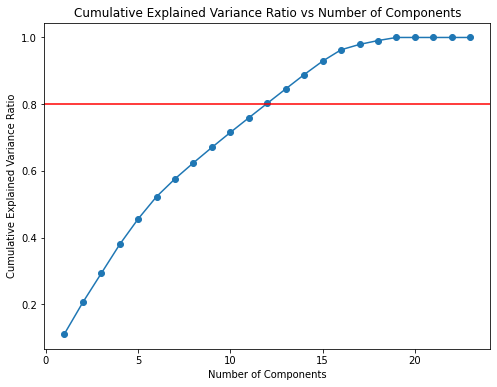

In [109]:
# Finds optimal num components to use (n) by plotting explained variance ratio (2 points)
# Plot (1 point for correct shape)
# Aesthetics (1 point for title AND both axes labels)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 24), cum_evr, marker='o')
plt.axhline(y=0.8, color='r', linestyle='-')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs Number of Components')
plt.show()

In [95]:
# Grader (2 points)
grader.grade(test_case_id = 'check_pca_explained_variance', answer = (explained_variance_ratios, cum_evr))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


_**Final PCA**_

Using your results above to help you decide the number of components to keep, choose a number (`n`) that explains **at least 80% of total variance** in the dataset. Then re-fit and transform your PCA on the training set using the number of components you decided.

Remember that your PCA should be trained on the training set (`x_train`) but only transformed on the test set (`x_test`).

Call your transformed set of principal components `x_test_pca` in order to submit it to the autograder.

In [188]:
# Addresses scale-invariance
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

In [189]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# TO-DO: Get transformed set of principal components on x_test
# 1. Refit and transform on training with parameter n (as deduced from the last step) 
n = 12
pca = PCA(n_components=n).fit(x_train_scaled)

# 2. Transform on Testing Set and store it as `x_test_pca`
x_test_scaled = scaler.transform(x_test)
x_test_pca = pca.transform(x_test_scaled)

In [190]:
# Grader (2 points)
grader.grade(test_case_id = 'check_fitted_pca', answer = x_test_pca)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### (e) Logistic Regression with PCA

1. Fit the logistic regression on your Final Principal Components data using your optimal `n`. Name the model `log_reg_pca`
2. Make predictions on the test set.
3. Report accuracy for the test set and call it `test_accuracy`

In [ ]:
# TO-DO: Initialize `log_reg_pca` model with default parameters and fit it on the PCA transformed training set


# TO-DO: Use the model to predict on the PCA transformed test set and save these predictions as `y_pred`


# TO-DO: Find the accuracy and store the value in `test_accuracy`


In [ ]:
# Grader (4 points)
grader.grade(test_case_id = 'check_log_reg_pca', answer = (test_accuracy, log_reg_pca.n_features_in_))

# **Part II:** Distributed Machine Learning with Spark (32 points)

Apache Spark ML is a machine learning library that consists of common learning algorithms and utilities, including classification, regression, clustering, collaborative filtering, dimensionality reduction, and underlying optimization primitives.

**Why Spark ML?**

Standard implementations of machine learning algorithms require very powerful machines to be able to run. However, depending on high-end machines is not advantageous due to their high price and improper costs of scaling up. The idea of using distributed computing engines is to distribute the calculations to multiple low-end machines (commodity hardware) instead of a single high-end one. _This **definitely speeds up** the learning phase and allows us to create better models._

Read more about it with the python documentation **[here](https://spark.apache.org/docs/latest/ml-guide.html)**.

Run the code below to set up Spark.

**Note:** The cell below may take up to 4-5 minutes to run

In [ ]:
## RUN BUT DO NOT MODIFY ANY OF THIS CODE
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [ ]:
## RUN BUT DO NOT MODIFY ANY OF THIS CODE
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('ml-hw4').getOrCreate()

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
## RUN BUT DO NOT MODIFY ANY OF THIS CODE

# Graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
## RUN BUT DO NOT MODIFY ANY OF THIS CODE
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

#### **2.1** Initializing Spark Data

We have the spark setup ready. Now we need the data for our ML algorithms. We will use the data you processed in Section 1 but in Spark. 

Read in the ```combined_df``` that you created in 1.4.3(a) into a Spark dataframe (`sdf`) and name the SDF as `data_sdf`. Make sure to set the inferSchema flag to True when you do this so that the columns are the correct datatypes and not all strings.

In [ ]:
#TODO: Read in the combined_df dataframe into a Spark Dataframe(.sdf)


Print out the Dataframe Schema and verify the datatypes. If you did everything correctly so far, the schema should be:
```
root
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- construction_year: double (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- price: double (nullable = true)
 |-- total_host_listings: double (nullable = true)
 |-- availability_365: double (nullable = true)
 |-- cancellation_factor: long (nullable = true)
 |-- host_identity_verified_unconfirmed: long (nullable = true)
 |-- host_identity_verified_verified: long (nullable = true)
 |-- borough_Bronx: long (nullable = true)
 |-- borough_Brooklyn: long (nullable = true)
 |-- borough_Manhattan: long (nullable = true)
 |-- borough_Queens: long (nullable = true)
 |-- borough_Staten Island: long (nullable = true)
 |-- instant_bookable_False: long (nullable = true)
 |-- instant_bookable_True: long (nullable = true)
 |-- room_type_Entire home/apt: long (nullable = true)
 |-- room_type_Hotel room: long (nullable = true)
 |-- room_type_Private room: long (nullable = true)
 |-- room_type_Shared room: long (nullable = true)
 |-- rating_boolean: double (nullable = true)
 ```

In [ ]:
# TO-DO: Verify that the schema of your Spark dataframe matches the above


Great job, we have the processed data now. For Spark ML, we need to create a feature column which has all features concatenated and a single column for labels, which we already have!
We will use `VectorAssembler()` to create a feature vector from all categorical and numerical features and we call the final vector as “features”.
First list all columns in the data and store it in a list named all_columns.

In [ ]:
# TO-DO: store all column name in the data_sdf in a list called `all_columns`


Create a list of column(s) which you don't want to include in your features. Name this list `drop_columns`.

In [ ]:
# TO-DO: Create `drop_columns`


Now using `drop_columns` or otherwise, create a list called `columns_to_use` that contains the names of all other columns that would be used as features for the ML models.

In [ ]:
# TO-DO: Create `columns_to_use` list


In [ ]:
# Grader (2 points)
grader.grade(test_case_id = 'check_columns_to_use', answer = columns_to_use)

Create a VectorAssembler object with columns you want to use. Name your output column as `features` (i.e. they are the features you wanna use later).

In [ ]:
# TO-DO: Import required library and create VectorAssembler object (to be used later)


## **2.2** Create Pipeline

Now we will create a pipeline. For this data, we just need a single stage with the assembler, but you could have other stages before that where you perform operations on the data like converting categorical strings in the features to numeric values, or do feature scaling operations.

In this step, we will create a pipeline with a single stage — the assembler. Fit the pipeline to your data and create the transformed dataframe and name it `modified_data_sdf`.

In [ ]:
# TO-DO: Import required libraries


# TO-DO: Define a pipeline object


# TO-DO: Fit and transform the pipeline on the data and store the transformed sdf as `modified_data_sdf`



Now that we have the data in the format we need, we will create our train and test sets.

Conduct a train-test split where 80% of the data is assigned to the training set while the remaining 20% is assigned to the testing set.

**Clarifications:**
- Name these `train_sdf` and `test_sdf` respectively.
- Set the variable `random_seed` to 42 and then add the argument `seed = random_seed` in the function to fix the random state in order to ensure consistency with our results.

In [ ]:
# TO-DO: Assign appropriate value to the random_seed variable
random_seed = 

# TO-DO: Do 80/20 train-test split with seed = random_seed and store them as "train_sdf" and "test_sdf"


In [ ]:
# Grader (3 points)
grader.grade(test_case_id = 'check_train_test_split_spark', answer = (train_sdf.count(), test_sdf.count(), random_seed))

***Manual Grading (1 point):*** The sections 2.3, 2.4 and 2.5 have a manual grading component of *1 point*. We will be manually going through your modeling structure. There will be negative points (penalties) for grave mistakes in modeling (Example: Using test data for training, not calculating the predictions on appropriate data sets, etc.)

## **2.3** LASSO Regularized Logistic Regression

**Logistic Regression Using SparkML**

Time to do the cool stuff! Let's train a Logistic Regression model to our data and try to predict whether the rating will be `high` or `low`.

This time, we will use "Big" data tools to help us build a Logistic Regression model for binary classification.

Look up the documentation online and try to understand how to implement this.

**Model 1: Train a Model without any Regularization.**

In [ ]:
# TO-DO: Import required library for Logistic Regression


# TO-DO: Instantiate and fit Logistic Regression model to training data



Calculate the training accuracy using the model's summary and store it in a variable named `train_accuracy`

In [ ]:
# TO-DO: Get training accuracy and store it as `train_accuracy`


Now, find out how good the model actually is and see if it overfits to the training data.

Predict the label `rating_boolean` for your test data and store them as `predictions` _(Hint: it is called 'transform' in Spark ML)_

In [ ]:
# TO-DO: Make predictions on testing set and store it as `predictions`


**Confusion Matrix**(Binary Classification): \\
A confusion matrix is used to consolidate the predictive performance of a model into a single table. In a binary classification scenario, it looks like this: \\
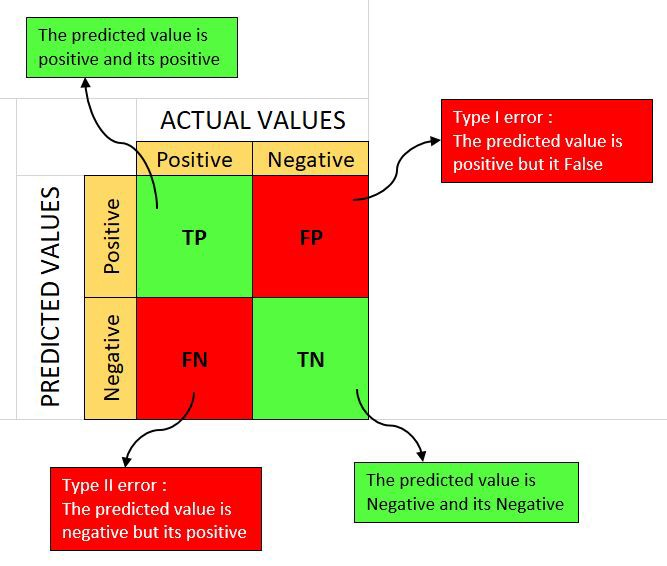 \\
Given the confusion matrix, we can calculate accuracy, precision, recall, F1 score and other metrics. For example, the formula for accuraccy would be: \\


> Accuracy = $\frac{TP + TN}{TP + FP + TN + FN}$



Evaluate the performance using the Confusion Matrix using `MulticlassMetrics` object in the Spark ML Regression library. Store the Confusion Matrix as an numpy array named  ```cm```. \\
**Note:** It might be useful to look at the documentation [here](https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html) and [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.evaluation.MulticlassMetrics.html) \\
For this section, you can ignore any warning messages that may appear.


In [ ]:
# TO-DO: Import required libraries


# TO-DO: Select appropriate columns to use MulticlassMetrics


# TO-DO: Instantiate metrics objects


# TO-DO: Create confusion matrix and store it as a numpy array named "cm"


Calculate the accuracy from the Confusion Matrix obtained above, and store it in a variable named ```test_accuracy```.

In [ ]:
# TO-DO: Calculate the test accuracy from the Confusion Matrix obtained and store it as "test_accuracy"


In [ ]:
# Grader (6 points)
grader.grade(test_case_id = 'check_logistic_without_reg', answer = (train_accuracy, test_accuracy, cm))

**Model 2: Train a Model with Regularization.**

Now, we will add regularization to avoid overfitting. 

Play around with different regularization parameters - try out LASSO (L1), Ridge (L2) and elastic net (combination of L1 and L2) and different regularization hyperparameters when initializing 3 different regularized logistic regression models. 

Compare these with each other and the non regularized regression done above.

Make sure to evaluate the performance on test data using the same methodology as above (calculating Confusion Matrix and then accuracy).

In [ ]:
# TO-DO: Instantiate LASSO/L1 regularized model as "l1_model"


# TO-DO: Fit and Transform "l1_model"


# TO-DO: Obtain Confusion matrix and then calculate test accuracy as done in previous section. 


# TO-DO: Store the Confusion matrix(and convert it to numpy array) on test set as "cm_l1_reg" and the test accuracy as "l1_accuracy"



In [ ]:
# TO-DO: Instantiate Ridge/L2 regularized model as "l2_model" 


# TO-DO: Fit and Transform "l2_model"


# TO-DO: Obtain Confusion matrix and then calculate test accuracy as done in previous section


# TO-DO: Store the Confusion matrix(and convert it to numpy array) on test set as `cm_l2_reg` and the test accuracy as `l2_accuracy`



In [ ]:
# TO-DO: Instantiate Elastic model with your choice of parameters as `elastic_model`


# TO-DO: Fit and Transform `elastic_model`


# TO-DO: Obtain Confusion matrix and then calculate test accuracy as done in previous section


# TO-DO: Store the Confusion matrix(and convert it to numpy array) on test set as `cm_elastic_reg` and the test accuracy as `elastic_accuracy`



In [ ]:
# Grader (6 points)
grader.grade(test_case_id = 'check_logistic_with_reg', answer = (l1_model.getElasticNetParam(), l1_model.getRegParam(), l1_accuracy, 
                                                                 l2_model.getElasticNetParam(), l2_model.getRegParam(), l2_accuracy, 
                                                                 elastic_model.getElasticNetParam(), elastic_model.getRegParam(), elastic_accuracy,
                                                                 cm_l1_reg, cm_l2_reg, cm_elastic_reg))

## **2.4** Random Forest

If you are looking to win Kaggle competitions, you definitely must know about Random Forests, Boosted Trees, etc. These ensemble methods generalize and work surprisingly well for a lot of classification problems and sometimes for regression problems (though regression trees are not the focus of this course).

Let's give it a go. Similar to what you did for the Logistic Regression model, create a Random Forest classifier model and name it `rf` and fit it to the training data. Call the fitted model `rf_model`

**Note1:** Set the `random_seed` to 42 and set the argument `seed = random_seed` while creating `rf` as a RandomForest object \\
**Note2:** Set `maxDepth` to a reasonable value lesser than 10

In [ ]:
# TO-DO: Import required libraries


# TO-DO: Set random_seed to appropriate value
random_seed =


# TO-DO: Instantiate  RF Model and call it `rf`. Then fit it to training data



This time, get predictions on both the training and testing sets and store them as `train_pred` and `test_pred` respectively

In [ ]:
# TO-DO: Get predictions and save to "train_pred" and "test_pred" respectively


Evaluate using the accuracy metric again. Store the training accuracy in a variable named ```rf_train_accuracy``` and the test accuracy in a variable named ```rf_test_accuracy```

In [ ]:
# TO-DO: Calculate the confusion matrices(and convert them to numpy arrays) for train set and test set
#        and call these `rf_train_cm` and `rf_test_cm` respectively


# TO-DO: Evaluate predictions using accuracy for both train and test
#        and call these `rf_train_accuracy` and `rf_test_accuracy` respectively


In [ ]:
# Grader (6 points)
grader.grade(test_case_id = 'check_random_forest', answer = (rf_train_accuracy, train_pred.count(), 
                                                             rf_test_accuracy, test_pred.count(),
                                                             rf.getSeed(), rf_train_cm, rf_test_cm))

##**2.5** Dimensionality Reduction Using PCA

We will again use the powerful PCA to reduce the dimensions and project the data onto a lower dimensional space and fit a logistic regression on the new projected data.

You will need to choose a new appropriate value for the number of dimensions.

_Steps for this section:_
1.   Initialize a PCA model called `pca` with the appropriate number of dimensions
2.   Fit the model using the training data
3.   Get the PCA features from the trained model
4.   Instantiate a Logistic Regression model object called `lr_model`
5.   Train the Logistic Regression model using the PCA features
6.   Evaluate the performance on the training set and test set using the accuracy

Store the training accuracy in a variable named ```training_acc_pca``` and test accuracy in a variable named ```test_acc_pca```

**Hint**: Choose `k` for PCA using the explained variance plot you made earlier

In [ ]:
# TO-DO: Import required libraries


# TO-DO: Perform intermediate steps to address scale-variance in PCA


# TO-DO: Instantiate PCA object as "pca" and then fit and transform. Make sure you make a reasonable choice for number of Principal components


# TO-DO: Instantiate Logistic Regression model and call the model object "lr_model"


# TO-DO: Fit Logistic Regression Model and get predictions



In [ ]:
# TO-DO: Calculate the confusion matrix(and convert it to numpy array) for train set and call it "pca_train_cm"


# TO-DO: Evaluate predictions on train using accuracy and call this "training_acc_pca"


# TO-DO: Calculate the confusion matrix(and convert it to numpy array) for test set and call it "pca_test_cm"


# TO-DO: Evaluate predictions on test using accuracy and call this "test_acc_pca"



In [ ]:
# Grader (8 points)
grader.grade(test_case_id = 'check_pca', answer = (training_acc_pca, test_acc_pca,
                                                   pca.getK(), len(lr_model.coefficients),
                                                   pca_train_cm, pca_test_cm))

# Homework Submission

Good job! You have finished the homework :) The submission instructions are as follows:

* **Double check** that you have the correct PennID (all numbers) in the autograder. 

* **Triple check** that you have all plots shown in this Colab notebook before submitting (otherwise, your submission will be subjected to a **penalty of -5 points**).

*  Go to the "File" tab at the top left of the Colab UI, click "Download .ipynb" and then "Download .py".  **Rename** these two files to `homework4.ipynb` and `homework4.py` respectively and upload them to Gradescope.
  - <ins>**WAIT UNTIL THE GRADESCOPE AUTOGRADER FINISHES RUNNING!**</ins> If we have to manually upload this for you after the deadline, **we will apply a penalty of -5 points** (this stacks with any other penatlies)

* You must submit your notebook to receive credit. Post any issues with submission on Ed Discussion and make sure to keep in mind the late day policy.

* After you submit your code, the teaching staff will manually grade your Colab notebook in order to validate the correctness of your code.